In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
train = dd.read_csv("train.csv").set_index('ts_id').compute()
features = pd.read_csv("features.csv", index_col = 0)
example_test = pd.read_csv("example_test.csv", index_col = 'ts_id')
example_sample_submission  = pd.read_csv("example_sample_submission.csv", index_col = 'ts_id')

In [4]:
print('train shape is {}'.format(train.shape))
print('features shape is {}'.format(features.shape))
print('example_test shape is {}'.format(example_test.shape))
print('sample_prediction_df shape is {}'.format(example_sample_submission.shape))

train shape is (2390491, 137)
features shape is (130, 29)
example_test shape is (15219, 132)
sample_prediction_df shape is (15219, 1)


In [5]:
train

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
ts_id,,,,,,,,,,,,,,,,,,,,,
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,...,NaN,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390486,499,0.000000,0.000142,0.000142,0.005829,0.020342,0.015396,1,-1.649365,-1.169996,...,-2.421753,-1.896874,-1.260055,1.947725,-1.994399,-1.685163,-2.866165,-0.216130,-1.892048,0.901585
2390487,499,0.000000,0.000012,0.000012,-0.000935,-0.006326,-0.004718,1,2.432943,5.284504,...,-0.677511,-0.936553,1.064936,3.119762,-0.419796,-0.208975,-0.146749,0.730166,0.648452,2.068737
2390488,499,0.000000,0.000499,0.000499,0.007605,0.024907,0.016591,1,-0.622475,-0.963682,...,-0.459167,-2.956745,-0.640334,-2.279663,-0.950259,-4.388417,-1.669922,-3.288939,-1.336142,-2.814239


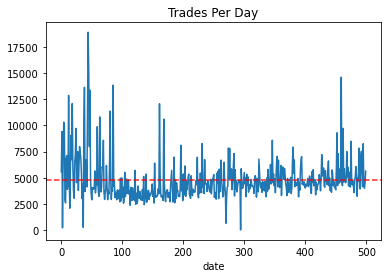

In [6]:
cnt = train[['date', 'weight']].groupby('date').agg(['count'])
cnt_mean = cnt.mean().values[0]
cnt.plot(legend = False, title = 'Trades Per Day');
plt.axhline(cnt_mean, linestyle = '--', alpha = 0.85, c = 'r');

In [7]:
train['resp'].mean()

0.00040831128805424865

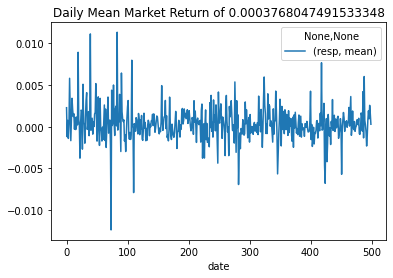

In [8]:
daily_average_return = train[['date', 'resp']].groupby('date').agg(['mean'])
daily_average_return.plot(title = f'Daily Mean Market Return of {daily_average_return.mean().values[0]}');

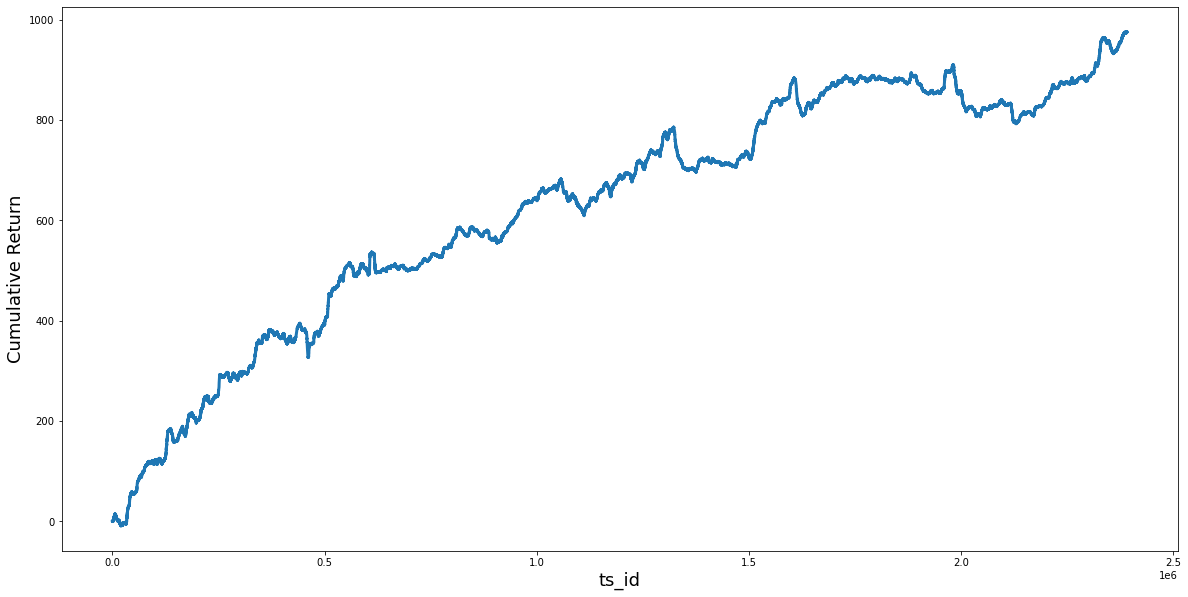

In [9]:
fig, ax = plt.subplots(figsize = (20, 10))
Cumulative_Return = pd.Series(train['resp']).cumsum()
ax.set_xlabel("ts_id", fontsize = 18)
ax.set_ylabel("Cumulative Return", fontsize = 18);
Cumulative_Return.plot(lw = 3);

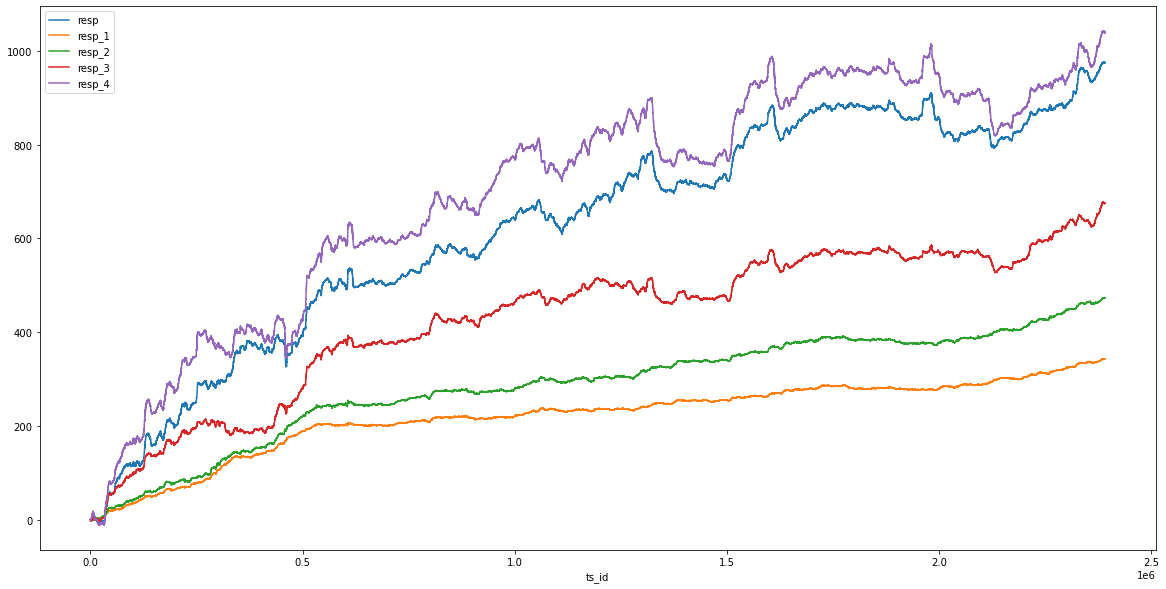

In [10]:
fig, ax = plt.subplots(figsize = (20, 10))
Cumulative_Return = pd.Series(train['resp']).cumsum()
resp_1 = pd.Series(train['resp_1']).cumsum()
resp_2 = pd.Series(train['resp_2']).cumsum()
resp_3 = pd.Series(train['resp_3']).cumsum()
resp_4 = pd.Series(train['resp_4']).cumsum()
Cumulative_Return.plot(lw = 1.5)
resp_1.plot(lw = 1.5)
resp_2.plot(lw = 1.5)
resp_3.plot(lw = 1.5)
resp_4.plot(lw = 1.5)
plt.legend(loc = "upper left");

In [11]:
Min_resp = train['resp'].min()
print('The Minimum value for resp is: %.5f' % Min_resp)
Max_resp = train['resp'].max()
print('The Maximum value for resp is:  %.5f' % Max_resp)
Max_weight = train['weight'].max()
print('The Maximum weight is: %.2f' % Max_weight)
Min_weight = train['weight'].min()
print('The Minimum Weight is: %.2f' % Min_weight)

The Minimum value for resp is: -0.54938
The Maximum value for resp is:  0.44846
The Maximum weight is: 167.29
The Minimum Weight is: 0.00


In [12]:
all_columns = train.columns
columns = all_columns[train.columns.str.contains('feature')]

In [13]:
%%time
cardinality = train[columns].nunique()

Wall time: 1min 14s


In [14]:
cardinality.sort_values()

feature_0            2
feature_43       20429
feature_52       47829
feature_69       70851
feature_53       77641
                ...   
feature_119    2383525
feature_59     2388561
feature_58     2390375
feature_57     2390466
feature_64     2390491
Length: 130, dtype: int64

In [15]:
train['feature_0'].value_counts()

 1    1207005
-1    1183486
Name: feature_0, dtype: int64

In [16]:
features

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,...,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
feature,,,,,,,,,,,,,,,,,,,,,
feature_0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feature_1,False,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
feature_2,False,False,False,False,False,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
feature_3,False,False,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
feature_4,False,False,False,False,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_125,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
feature_126,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
feature_127,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


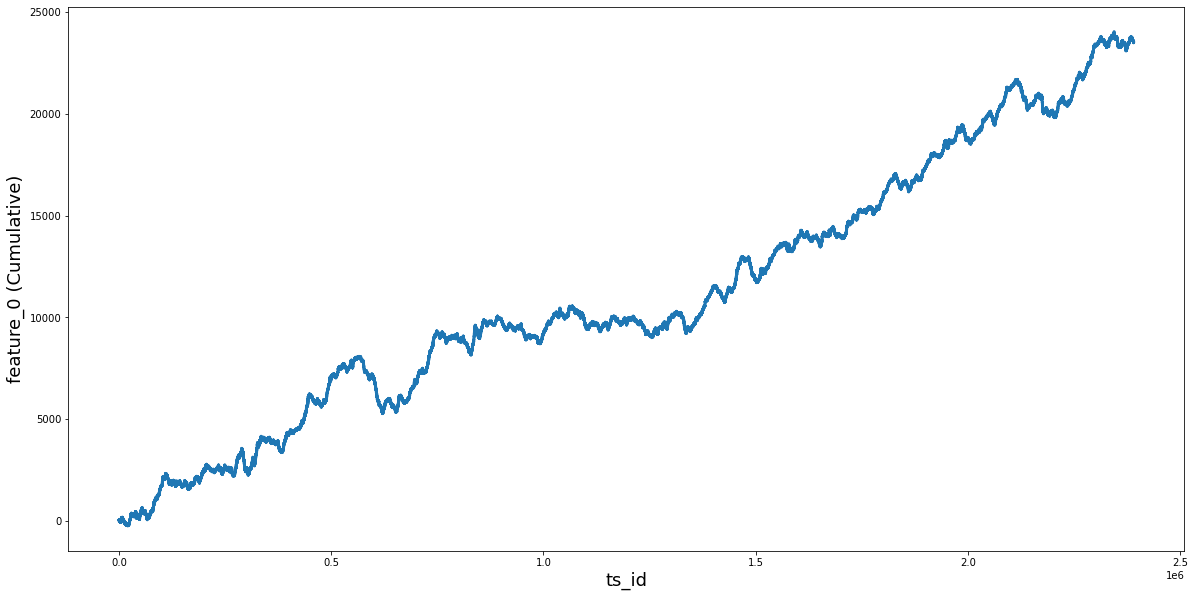

In [17]:
fig, ax = plt.subplots(figsize = (20, 10))
feature_0 = pd.Series(train['feature_0']).cumsum()
ax.set_xlabel("ts_id", fontsize = 18)
ax.set_ylabel("feature_0 (Cumulative)", fontsize = 18);
feature_0.plot(lw = 3)

In [18]:
features

,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,...,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
feature,,,,,,,,,,,,,,,,,,,,,
feature_0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
feature_1,False,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
feature_2,False,False,False,False,False,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,False
feature_3,False,False,False,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
feature_4,False,False,False,False,False,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_125,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
feature_126,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
feature_127,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [19]:
features = features * 1
features.T.style.background_gradient(cmap = 'BuPu')

In [20]:
tag_sum = pd.DataFrame(features.T.sum(axis = 0), columns = ['Number of tags'])
tag_sum.T

feature,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
Number of tags,0,2,3,2,3,2,3,3,4,3,...,2,3,2,3,2,3,2,3,2,3


In [21]:
def missing(dff):
    print (round((dff.isnull().sum() * 100 / len(dff)), 2).sort_values(ascending = False))
missing(train)

feature_18    16.55
feature_28    16.55
feature_27    16.55
feature_17    16.55
feature_7     16.45
              ...  
feature_53     0.00
feature_54     0.00
feature_57     0.00
feature_58     0.00
date           0.00
Length: 137, dtype: float64


In [22]:
resp_train = train.loc[:,train.columns.str.contains('resp')]
weight_train = train.loc[:,train.columns.str.contains('weight')]
missing(resp_train)
missing(weight_train)

resp      0.0
resp_4    0.0
resp_3    0.0
resp_2    0.0
resp_1    0.0
dtype: float64
weight    0.0
dtype: float64


In [33]:
train = train[train['weight'] != 0]
train['action'] = ((train['weight'].values * train['resp'].values) > 0).astype('int')

In [24]:
X_train = train.loc[:,train.columns.str.contains('feature')]
y_train = train.loc[:,'action']

In [25]:
X_train = X_train.fillna(-999)

In [26]:
X_train

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
ts_id,,,,,,,,,,,,,,,,,,,,,
1,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,-999.000000,-999.000000,-0.151877,...,-999.000000,-999.000000,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684
4,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,-999.000000,-999.000000,2.683018,...,-999.000000,-999.000000,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633
6,-1,-3.172026,-3.093182,-0.030588,-0.043175,0.097058,0.053483,-999.000000,-999.000000,-6.299415,...,-999.000000,-999.000000,0.336873,4.076447,0.614783,6.622176,0.800618,5.231595,0.361506,3.921714
7,-1,0.446050,-0.466210,0.498751,0.244116,0.412528,0.224140,-999.000000,-999.000000,0.277257,...,-999.000000,-999.000000,2.101997,4.846202,1.479875,5.261328,2.305066,4.571762,2.201537,4.429745
8,1,-3.172026,-3.093182,-0.363836,-0.291496,0.128422,0.096168,-999.000000,-999.000000,-3.727364,...,-999.000000,-999.000000,1.537913,4.785838,1.637435,6.968002,2.354338,5.825499,1.778029,4.740577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390444,-1,1.538675,2.530447,2.494852,3.263345,1.613620,2.097220,-0.401539,-0.489412,-0.045341,...,-1.872247,-2.084489,-0.984942,1.129901,-1.632432,-2.169964,-2.371293,-0.889212,-1.554352,0.215984
2390446,1,0.270380,-1.231874,-5.802676,-3.172423,-4.357278,-2.301009,1.957683,1.000846,4.245754,...,1.210442,-1.982950,1.724863,-0.984278,1.413825,-1.598825,2.087731,-1.126050,1.590538,-1.250209
2390478,-1,-0.134380,0.160580,1.292513,1.453954,0.605912,0.687598,-0.489143,-0.593642,-0.915392,...,-0.342937,-2.103206,-0.765664,-2.148415,-0.599358,-3.155134,-0.957971,-2.285314,-0.894580,-2.064227


In [27]:
y_train

ts_id
1          0
4          0
6          1
7          1
8          0
          ..
2390444    0
2390446    0
2390478    0
2390481    0
2390489    0
Name: action, Length: 1981287, dtype: int32

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import learning_curve,StratifiedKFold

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train,random_state = 42)

In [30]:
model = xgb.XGBClassifier(
    n_estimators = 150,
    max_depth = 6,
    learning_rate = 0.01,
    subsample = 0.5,
    colsample_bytree = 0.7,
    missing = 0,
    gamma = 0.4,
    min_child_weight = 1,
    random_state = 0,
    # tree_method='gpu_hist'
)

In [31]:
import janestreet
# initiation of the environment
env = janestreet.make_env()
# an iterator to loops over the test set
iter_test = env.iter_test()

ModuleNotFoundError: No module named 'janestreet'

In [32]:
for (test_df, sample_prediction_df) in iter_test:
    #We will specify the X_test from our test data (features)
    X_test = test_df.loc[:, test_df.columns.str.contains('feature')]
    #Replace the missing value with -999
    X_test.fillna(0)
    #Predict using our X_test
    y_preds = model.predict(X_test)
    #Make / store our prediction results in sample_pred_df
    sample_prediction_df.action = y_preds
    env.predict(sample_prediction_df)

NameError: name 'iter_test' is not defined